<a href="https://colab.research.google.com/github/jellaljoestar/covid_19-EXL-/blob/main/covid_county_wise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**SOLUTION CODE**



---



**Importing Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
%matplotlib inline


# **Data Sample Cleaning and Analysis**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA/EQ_2021_Data_Sample.csv', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1179375 entries, 0 to 1179374
Data columns (total 82 columns):
 #   Column                                                                  Non-Null Count    Dtype  
---  ------                                                                  --------------    -----  
 0   countyFIPS                                                              1179375 non-null  int64  
 1   stateFIPS                                                               1179375 non-null  int64  
 2   date                                                                    1179375 non-null  object 
 3   confirmed_cases                                                         1179375 non-null  int64  
 4   deaths                                                                  1179375 non-null  int64  
 5   google_mobility_retail_and_recreation                                   566919 non-null   float64
 6   google_mobility_grocery_and_pharmacy                      

In [ ]:
df.shape

(1179375, 82)

In [ ]:
df.head()

,countyFIPS,stateFIPS,date,confirmed_cases,deaths,google_mobility_retail_and_recreation,google_mobility_grocery_and_pharmacy,google_mobility_parks,google_mobility_transit_stations,google_mobility_workplaces,google_mobility_residential,apple_mobility_driving,apple_mobility_transit,apple_mobility_walking,Electricity_Sales_ Revenue_Residential ($ x1000),Electricity_Sales_ Sales_Residential (MWHr),Electricity_Sales_ Customers_Count_Residential,Electricity_Sales_ Revenue_Commercial ($ x1000),Electricity_Sales_ Sales_Commercial (MWHr),Electricity_Sales_ Customers_Count_Commercial,Electricity_Sales_ Revenue_Industrial ($ x1000),Electricity_Sales_ Sales_Industrial (MWHr),Electricity_Sales_ Customers_Count_Industrial,Electricity_Sales_ Revenue_Transportation ($ x1000),Electricity_Sales_ Sales_Transportation (MWHr),Electricity_Sales_ Customers_Count_Transportation,DOMESTIC_Air_Passengers,INTERNATIONAL_Air_Passengers,DOMESTIC_Flights_Cnt,INTERNATIONAL_Flights_Cnt,YoY_Reopened_Seated_Diner_Data,test_count,test_rate,new_test_rate,new_test_count,C_PCTPOVALL_2019,C_PCTPOV017_2019,C_PCTPOV517_2019,C_MEDHHINC_2019,C_TOT_POP,...,C_WA_MALE,C_WA_FEMALE,C_MinorityPCT,C_BlackPCT,C_HispanicPCT,C_M_Labour_Force_corr,C_M_Employed_corr,C_M_Unemployment_Rate_corr,S_D_dly_new_test,S_D_cummulative_test,initclaims_count_regular_cw,initclaims_rate_regular_cw,spend_all_cd,merchants_all_cd,revenue_all_cd,critical_staffing_shortage_today_yes_SD,critical_staffing_shortage_anticipated_within_week_yes_SD,hospital_onset_covid_SD,hospital_onset_covid_coverage_SD,inpatient_beds_SD,inpatient_beds_coverage_SD,previous_day_admission_adult_covid_confirmed_SD,previous_day_admission_adult_covid_suspected_SD,previous_day_admission_pediatric_covid_confirmed_SD,previous_day_admission_pediatric_covid_suspected_SD,staffed_adult_icu_bed_occupancy_SD,staffed_adult_icu_bed_occupancy_coverage_SD,staffed_icu_adult_patients_confirmed_and_suspected_covid_SD,staffed_icu_adult_patients_confirmed_covid_SD,total_adult_patients_hospitalized_confirmed_and_suspected_covid_SD,total_adult_patients_hospitalized_confirmed_covid_SD,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_SD,total_pediatric_patients_hospitalized_confirmed_covid_SD,inpatient_beds_utilization_SD,inpatient_beds_utilization_numerator_SD,inpatient_beds_utilization_denominator_SD,percent_of_inpatients_with_covid_SD,inpatient_bed_covid_utilization_SD,adult_icu_bed_covid_utilization_SD,adult_icu_bed_utilization_SD
0,1001,1,2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,101.51,NaN,NaN,670692.302,5414230.614,4585564.0,398194.878,3435710.506,744182.0,309206.548,5512107.536,16298.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,.,.,.,.,12.1,15.9,14.4,58233.0,55514.0,...,21383.0,22185.0,0.2364,0.18,0.0257,26127.0,25513.0,2.4,NaN,NaN,NaN,NaN,116.0,NaN,NaN,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003,1,2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,103.12,NaN,94.32,670692.302,5414230.614,4585564.0,398194.878,3435710.506,744182.0,309206.548,5512107.536,16298.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,.,.,.,.,10.1,13.5,13.3,59871.0,190790.0,...,81423.0,85193.0,0.1679,0.10,0.0458,95993.0,93689.0,2.4,NaN,NaN,NaN,NaN,269.0,-17.0,-495.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1005,1,2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,120.67,NaN,NaN,670692.302,5414230.614,4585564.0,398194.878,3435710.506,744182.0,309206.548,5512107.536,16298.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,.,.,.,.,27.1,41.0,39.5,35972.0,27201.0,...,7397.0,6338.0,0.5355,0.47,0.0509,8624.0,8349.0,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1007,1,2020-01-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,111.18,NaN,NaN,670692.302,5414230.614,4585564.0,398194.878,3435710.506,744182.0,309206.548,5512107.536,16298.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,.,.,.,.,20.3,25.9,25.2,47918.0,22597.0,...,8903.0,8326.0,0.2545,0.22,0.0204

In [ ]:
df.replace('.', '0', inplace=True)

**Changing Datatypes accordingly**

In [ ]:
df.iloc[:,31:35] = df.iloc[:,31:35].astype('float64')

In [ ]:
df['date'] = pd.to_datetime(df['date'])


In [ ]:
df.iloc[:,4] = df.iloc[:,4].astype('float64')

In [ ]:
df.info()

**Assumption: New Confirmed Cases started rising from 2020-03-01**



In [ ]:
df = df[(df['date'].dt.year == 2021) | (df['date'] >= '2020-03')]

In [ ]:
df.shape

(1056720, 82)

In [ ]:
df.info()

In [ ]:
df.corr()

**dropping Null values**

In [ ]:
df.dropna(subset=['C_M_Labour_Force_corr','C_M_Employed_corr'],inplace=True)

In [ ]:
df.describe()

### Removing variables of lesser relevance

In [ ]:
df.drop(df.columns[[12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,35,36,37,38,40,41,42,43,44,45,46,49,52,53,54,55,56]],axis=1, inplace=True)

In [ ]:
df.shape

(961146, 46)

**Replacing Null Values**

In [ ]:
df[['S_D_dly_new_test','S_D_cummulative_test']].fillna(0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
df = df.fillna(df.mean())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


### Combined Mobility

**Combining google mobility features by taking mean to check for correlation with confirmed cases**

In [ ]:
df['ToT_mobility'] = df.iloc[:,5:10].mean(axis=1)

In [ ]:
df.info()

In [ ]:
df.corr()


### Converting State data to County data according to Population Distribution

In [ ]:
df['S_TOT_POP'] = df['C_TOT_POP'].groupby(df['stateFIPS']).transform('sum')

In [ ]:
df['ratio'] = df['C_TOT_POP']/df['S_TOT_POP']

In [ ]:
df.iloc[:,19:46] = df.iloc[:,19:46].mul(df['ratio'],axis=0)

In [ ]:
df.iloc[:,12:16] = df.iloc[:,12:16].mul(df['ratio'],axis=0)

In [ ]:
df.corr()

In [ ]:
df['S_TOT_POP'].unique()

In [ ]:
df.info()

### Dropping features eliminated by Filter Method

In [ ]:
df.drop(df.columns[[4,5,6,7,8,9,10,11,13,14,20,23,28,29,30,37,38,39,42,43,44,45,47,48]],axis=1, inplace=True)


In [ ]:
df.info()

## Visualisation of data

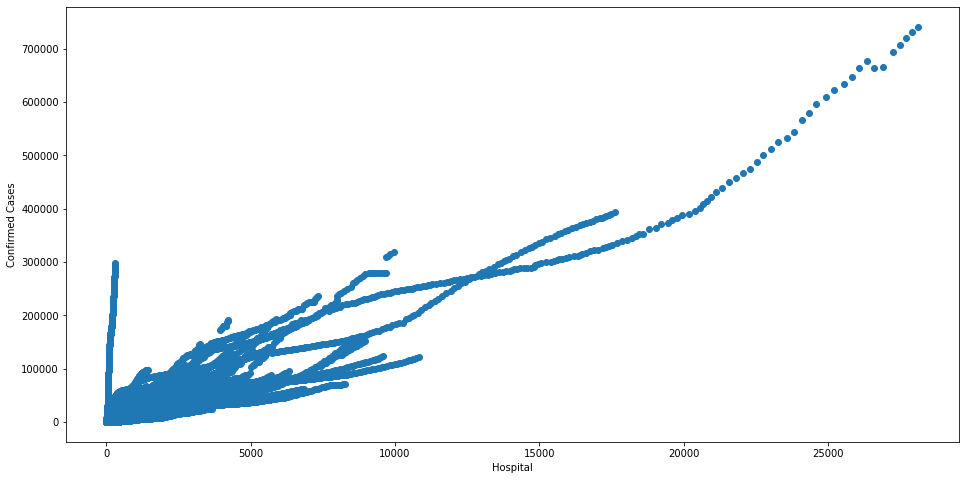

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df['test_count'],df['confirmed_cases'])
ax.set_xlabel('Hospital')
ax.set_ylabel('Confirmed Cases')
plt.show()

**Similar scatter plots were observed from other features. outliers are steering the association between the variables and confirmed cases**

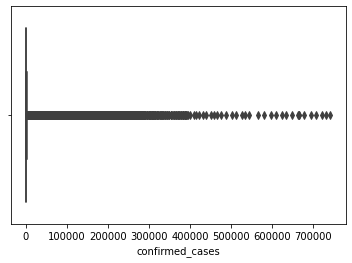

In [ ]:
sns.boxplot(x=df['confirmed_cases'])

**BOX plot also shows evidence of outliers affecting the real usable data**

## Removing Outliers

In [ ]:
df1 = df.iloc[:,3:]


### IQR Method

In [ ]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1
df1 = df1[~((df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
df1.describe()

,confirmed_cases,test_count,new_test_count,C_TOT_POP,C_M_Labour_Force_corr,C_M_Employed_corr,S_D_dly_new_test,critical_staffing_shortage_today_yes_SD,critical_staffing_shortage_anticipated_within_week_yes_SD,hospital_onset_covid_coverage_SD,inpatient_beds_SD,inpatient_beds_coverage_SD,previous_day_admission_adult_covid_confirmed_SD,staffed_adult_icu_bed_occupancy_SD,staffed_adult_icu_bed_occupancy_coverage_SD,staffed_icu_adult_patients_confirmed_and_suspected_covid_SD,staffed_icu_adult_patients_confirmed_covid_SD,total_adult_patients_hospitalized_confirmed_and_suspected_covid_SD,total_adult_patients_hospitalized_confirmed_covid_SD,inpatient_beds_utilization_numerator_SD,inpatient_beds_utilization_denominator_SD,ToT_mobility
count,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,5.970750e+05,5.970750e+05,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000
mean,227.932220,11.662391,0.131533,20824.195659,9376.649064,8635.691288,0.230989,0.000106,0.000127,0.001143,1.397517e-01,1.243407e-03,0.000673,0.005596,0.000614,0.001516,0.001345,0.005770,0.004746,0.087254,0.136057,-3.068443
std,354.312404,15.333470,0.154649,20358.086993,9674.603378,8795.297806,0.257529,0.000164,0.000193,0.001042,1.374335e-01,1.126753e-03,0.001031,0.008343,0.000850,0.002257,0.002004,0.008389,0.007123,0.088460,0.134096,3.042273
min,0.000000,0.000000,0.000000,71.000000,171.000000,161.000000,0.000000,0.000000,0.000000,0.000000,4.312587e-07,8.903808e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.166811
25%,7.000000,1.219388,0.025547,7505.000000,3171.000000,2946.000000,0.059308,0.000000,0.000000,0.000404,4.308735e-02,4.416263e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024215,0.041139,-3.829980
50%,65.000000,5.649336,0.077024,14827.000000,6316.000000,5845.000000,0.150844,0.000016,0.000027,0.000872,1.005997e-01,9.500894e-04,0.000130,0.000986,0.000163,0.000234,0.000258,0.001288,0.001000,0.061284,0.097807,-3.829980
75%,295.000000,15.995221,0.178520,26347.000000,11721.000000,10843.000000,0.297959,0.000155,0.000189,0.001558,1.888040e-01,1.696143e-03,0.000995,0.008730,0.001016,0.002382,0.002082,0.009107,0.007185,0.120830,0.185192,-1.954963
max,2064.000000,101.451233,1.115644,152218.000000,71299.000000,66117.000000,1.714492,0.000820,0.000992,0.007867,1.008289e+00,8.482987e-03,0.005718,0.048991,0.005215,0.012935,0.011394,0.049709,0.040580,0.657253,0.988907,6.238831


## Feature Selection by BE Method

In [ ]:
X = df1.iloc[:,1:]
Y = df1.iloc[:,0]

In [ ]:

import statsmodels.api as sm
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(Y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(len(selected_features_BE))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


19


In [ ]:
X = df1[selected_features_BE]
df1.corr()

In [ ]:
X.info()

**Final feature selection by eliminating similar features with high correlation**

In [ ]:
X.drop(X.columns[[2,3,4,5,7,17,18]],axis=1,inplace=True) #better

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df1.corr()

,confirmed_cases,test_count,new_test_count,C_TOT_POP,C_M_Labour_Force_corr,C_M_Employed_corr,S_D_dly_new_test,critical_staffing_shortage_today_yes_SD,critical_staffing_shortage_anticipated_within_week_yes_SD,hospital_onset_covid_coverage_SD,inpatient_beds_SD,inpatient_beds_coverage_SD,previous_day_admission_adult_covid_confirmed_SD,staffed_adult_icu_bed_occupancy_SD,staffed_adult_icu_bed_occupancy_coverage_SD,staffed_icu_adult_patients_confirmed_and_suspected_covid_SD,staffed_icu_adult_patients_confirmed_covid_SD,total_adult_patients_hospitalized_confirmed_and_suspected_covid_SD,total_adult_patients_hospitalized_confirmed_covid_SD,inpatient_beds_utilization_numerator_SD,inpatient_beds_utilization_denominator_SD,ToT_mobility
confirmed_cases,1.000000,0.720465,0.546357,0.214889,0.212896,0.222713,0.181488,0.589502,0.608145,0.372644,0.355590,0.346727,0.713359,0.638045,0.622960,0.682872,0.718045,0.725016,0.751012,0.417594,0.369978,0.126169
test_count,0.720465,1.000000,0.879953,0.389508,0.378121,0.385905,0.314855,0.565349,0.571325,0.460646,0.527680,0.438138,0.708773,0.805884,0.721382,0.705405,0.717737,0.768151,0.745127,0.600422,0.545946,0.204089
new_test_count,0.546357,0.879953,1.000000,0.601507,0.582402,0.579405,0.414176,0.392212,0.391489,0.571422,0.699505,0.575819,0.536288,0.646728,0.550277,0.555131,0.550691,0.616808,0.569335,0.747326,0.709058,0.224586
C_TOT_POP,0.214889,0.389508,0.601507,1.000000,0.964617,0.959377,0.474140,0.062953,0.063896,0.648987,0.811223,0.680888,0.103166,0.251730,0.165984,0.153675,0.142136,0.186381,0.138744,0.780055,0.800300,0.136871
C_M_Labour_Force_corr,0.212896,0.378121,0.582402,0.964617,1.000000,0.997619,0.468688,0.058567,0.058964,0.640557,0.783766,0.657463,0.092990,0.244678,0.172604,0.141640,0.132943,0.177247,0.128561,0.754078,0.773246,0.132271
C_M_Employed_corr,0.222713,0.385905,0.579405,0.959377,0.997619,1.000000,0.468049,0.070030,0.070849,0.631789,0.771341,0.649205,0.106507,0.258074,0.187418,0.154746,0.146459,0.190808,0.141732,0.742615,0.761285,0.128791
S_D_dly_new_test,0.181488,0.314855,0.414176,0.474140,0.468688,0.468049,1.000000,0.228399,0.235087,0.572241,0.467155,0.577205,0.132298,0.194242,0.292061,0.133278,0.141123,0.173245,0.154884,0.448113,0.466850,0.099780
critical_staffing_shortage_today_yes_SD,0.589502,0.565349,0.392212,0.062953,0.058567,0.070030,0.228399,1.000000,0.985306,0.371939,0.226779,0.323160,0.670460,0.682365,0.779385,0.725460,0.763404,0.708985,0.721019,0.287769,0.245900,0.116648
critical_staffing_shortage_anticipated_within_week_yes_SD,0.608145,0.571325,0.391489,0.063896,0.058964,0.070849,0.235087,0.985306,1.000000,0.379983,0.233315,0.331965,0.689082,0.697219,0.794423,0.743123,0.778478,0.724832,0.737241,0.295532,0.253024,0.120080
hospital_onset_covid_coverage_SD,0.372644,0.460646,0.571422,0.648987,0.640557,0.631789,0.572241,0.371939,0.379983,1.000000,0.820852,0.955409,0.317666,0.399402,0.485542,0.334209,0.338294,0.345694,0.336378,0.767221,0.816333,0.174255


## Regression Model Training and Testing

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X,Y,test_size = 0.2, random_state= 0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


In [ ]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)#predicting the test set results
y_pred = regressor.predict(X_test)
y_pred1 = regressor.predict(X_train)

In [ ]:
y_pred = [0 if i < 0 else i for i in y_pred]

### Checking for accuracy of the model using statistical metrics

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print('The mean square error of cases and predict value is: ', mse)

The mean square error of cases and predict value is:  41812.0709277742


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print('The mean absolute error of cases and predicted value is: ', mae)

The mean absolute error of cases and predicted value is:  112.76446140586276


In [ ]:
mse1 = mean_squared_error(y_train, y_pred1)
print('The mean square error of cases and predicted value is: ', mse1)

The mean square error of cases and predicted value is:  42338.693201912734


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


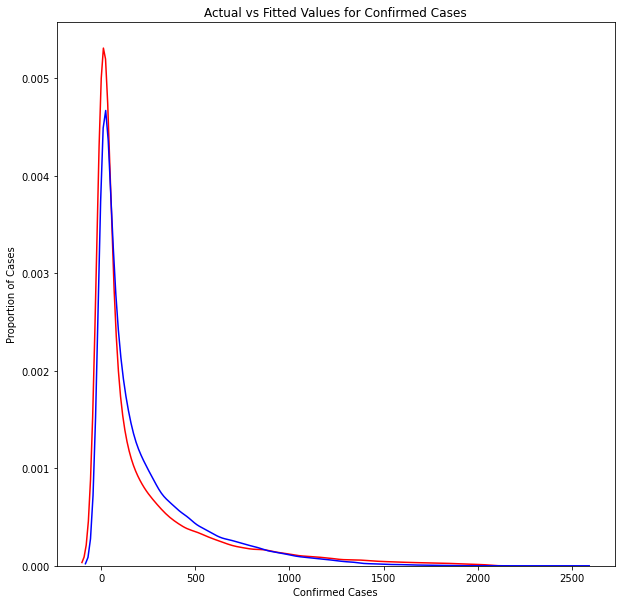

In [ ]:
plt.figure(figsize=(10, 10))


ax1 = sns.distplot(y_test, hist=False,  color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Confirmed Cases')
plt.xlabel('Confirmed Cases')
plt.ylabel('Proportion of Cases')
plt.show()
plt.close()

**R-Square**

In [ ]:
print('The R-square is: ', regressor.score(X_train, y_train))

The R-square is:  0.6632809802755842


**Final Features used in the model**

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597075 entries, 122657 to 1085024
Data columns (total 12 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   test_count                                                          597075 non-null  float64
 1   new_test_count                                                      597075 non-null  float64
 2   critical_staffing_shortage_anticipated_within_week_yes_SD           597075 non-null  float64
 3   inpatient_beds_coverage_SD                                          597075 non-null  float64
 4   previous_day_admission_adult_covid_confirmed_SD                     597075 non-null  float64
 5   staffed_adult_icu_bed_occupancy_SD                                  597075 non-null  float64
 6   staffed_adult_icu_bed_occupancy_coverage_SD                         597075 non-null  float64
 

In [ ]:
regressor.coef_

array([ 272.80659008, -140.44588558,   27.95104293,    4.94577156,
         34.0930026 ,  -98.33857924,   10.56664017,   -1.31302342,
         57.79377993,  -88.37001457,  166.57339763,   64.34553954])

# Validation Data Cleaning and Prediction

**Importing Validation Dataset from google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
validation_df = pd.read_csv('/content/drive/MyDrive/DATA/EQ-2021-Validation-Data-Sample_1.csv', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37,45,46) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Changing datatype into 'float64'**


In [ ]:
validation_df.iloc[:,31:35] = validation_df.iloc[:,31:35].astype('float64')
validation_df.iloc[:,4] = validation_df.iloc[:,4].astype('float64')
validation_df.iloc[:,45:47] = validation_df.iloc[:,45:47].apply(lambda col: pd.to_numeric(col, errors='coerce'))
validation_df.iloc[:,37] = validation_df.iloc[:,37].apply(lambda col: pd.to_numeric(col, errors='coerce'))
validation_df.iloc[:,45:47] = validation_df.iloc[:,45:47].astype('float64')
validation_df.iloc[:,37] = validation_df.iloc[:,37].astype('float64')
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47130 entries, 0 to 47129
Data columns (total 80 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   countyFIPS                                                              47130 non-null  int64  
 1   stateFIPS                                                               47130 non-null  int64  
 2   date                                                                    47130 non-null  object 
 3   google_mobility_retail_and_recreation                                   24498 non-null  float64
 4   google_mobility_grocery_and_pharmacy                                    21775 non-null  float64
 5   google_mobility_parks                                                   11009 non-null  float64
 6   google_mobility_transit_stations                                        14863 

In [ ]:
validation_df.corr()

### Removing variables of lesser relevance

In [ ]:
validation_df.drop(validation_df.columns[[8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,33,34,35,36,38,39,40,41,42,43,44,50,51,52,53,54]],axis=1, inplace=True)
validation_df.info()

**Replacing misssing values**

In [ ]:
validation_df = validation_df.fillna(validation_df.mean())

In [ ]:
validation_df.head()

## Combined Mobility

In [ ]:
validation_df['ToT_mobility'] =validation_df.iloc[:,3:8].mean(axis=1)
validation_df.info()

## Converting State data to County data according to Population Distribution

In [ ]:
validation_df['S_TOT_POP'] = validation_df['C_TOT_POP'].groupby(validation_df['stateFIPS']).transform('sum')

In [ ]:
validation_df['ratio'] = validation_df['C_TOT_POP']/validation_df['S_TOT_POP']

In [ ]:
validation_df.info()

In [ ]:
validation_df.iloc[:,16:43] = validation_df.iloc[:,16:43].mul(validation_df['ratio'],axis=0)

In [ ]:
validation_df.iloc[:,8:12] = validation_df.iloc[:,8:12].mul(validation_df['ratio'],axis=0)
validation_df.info()

## Removing Features Eliminated by BE Method

In [ ]:
validation_df.drop(validation_df.columns[[3,4,5,6,7,9,10]],axis=1, inplace=True)


## Prediction by Regression Model

In [ ]:
X_valid = validation_df[X.columns]

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_valid = sc_X.fit_transform(X_valid)


In [ ]:
validation_df['Confirmed_cases'] = regressor.predict(X_valid)

In [ ]:
validation_df['Confirmed_cases'][validation_df['Confirmed_cases'] < 0] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
validation_df.head()

,countyFIPS,stateFIPS,date,test_count,new_test_count,C_TOT_POP,C_M_Labour_Force_corr,C_M_Employed_corr,C_M_Unemployment_Rate_corr,S_D_dly_new_test,S_D_cummulative_test,critical_staffing_shortage_today_yes_SD,critical_staffing_shortage_anticipated_within_week_yes_SD,hospital_onset_covid_SD,hospital_onset_covid_coverage_SD,inpatient_beds_SD,inpatient_beds_coverage_SD,previous_day_admission_adult_covid_confirmed_SD,previous_day_admission_adult_covid_suspected_SD,previous_day_admission_pediatric_covid_confirmed_SD,previous_day_admission_pediatric_covid_suspected_SD,staffed_adult_icu_bed_occupancy_SD,staffed_adult_icu_bed_occupancy_coverage_SD,staffed_icu_adult_patients_confirmed_and_suspected_covid_SD,staffed_icu_adult_patients_confirmed_covid_SD,total_adult_patients_hospitalized_confirmed_and_suspected_covid_SD,total_adult_patients_hospitalized_confirmed_covid_SD,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_SD,total_pediatric_patients_hospitalized_confirmed_covid_SD,inpatient_beds_utilization_SD,inpatient_beds_utilization_numerator_SD,inpatient_beds_utilization_denominator_SD,percent_of_inpatients_with_covid_SD,inpatient_bed_covid_utilization_SD,adult_icu_bed_covid_utilization_SD,adult_icu_bed_utilization_SD,ToT_mobility,S_TOT_POP,ratio,Confirmed_cases
0,1001,1,01-02-2021,1645.859832,5.856841,55514.0,25029.0,24237.0,3.2,7.134739,2787.076555,0.024560,0.026863,0.009978,0.081356,11.600859,0.084426,0.176526,0.064471,0.003838,0.006908,1.109814,0.084426,0.469714,0.457434,1.555735,1.448285,0.019955,0.012280,0.000572,8.643657,11.600859,0.000144,0.000107,0.000289,0.000668,-17.791997,72330345.0,0.000768,200.720422
1,1001,1,02-02-2021,1637.732707,3.932703,55514.0,25029.0,24237.0,3.2,11.969262,2799.045817,0.023793,0.026863,0.012280,0.080588,11.567856,0.083658,0.195714,0.099776,0.003838,0.003070,1.136677,0.083658,0.465876,0.452061,1.495102,1.429097,0.019955,0.013815,0.000587,8.853953,11.567856,0.000135,0.000104,0.000288,0.000687,-15.191997,72330345.0,0.000768,203.427075
2,1001,1,03-02-2021,1642.401448,3.715498,55514.0,25029.0,24237.0,3.2,11.812690,2810.858507,0.026095,0.026863,0.012280,0.088263,11.959284,0.089798,0.168084,0.087496,0.004605,0.006908,1.134374,0.089798,0.462806,0.441316,1.528873,1.405304,0.024560,0.018420,0.000603,9.398115,11.959284,0.000128,0.000101,0.000288,0.000689,-11.591997,72330345.0,0.000768,202.082441
3,1001,1,04-02-2021,1649.896148,3.622630,55514.0,25029.0,24237.0,3.2,13.059888,2823.918395,0.025328,0.026863,0.017653,0.086728,11.956214,0.089798,0.158106,0.095171,0.000768,0.005373,1.116722,0.089798,0.445154,0.424431,1.461332,1.340834,0.022258,0.015350,0.000594,9.257662,11.956214,0.000126,0.000098,0.000276,0.000677,-15.391997,72330345.0,0.000768,200.454107
4,1001,1,05-02-2021,1649.896148,2.453718,55514.0,25029.0,24237.0,3.2,11.329929,2835.248324,0.025328,0.026095,0.011513,0.086728,11.904024,0.089798,0.181132,0.076751,0.004605,0.010745,1.101372,0.089798,0.411383,0.398336,1.442144,1.335461,0.022258,0.016118,0.000595,9.227729,11.904024,0.000125,0.000097,0.000258,0.000675,-16.991997,72330345.0,0.000768,202.109600


In [ ]:
df1.describe()

,confirmed_cases,test_count,new_test_count,C_TOT_POP,C_M_Labour_Force_corr,C_M_Employed_corr,S_D_dly_new_test,critical_staffing_shortage_today_yes_SD,critical_staffing_shortage_anticipated_within_week_yes_SD,hospital_onset_covid_coverage_SD,inpatient_beds_SD,inpatient_beds_coverage_SD,previous_day_admission_adult_covid_confirmed_SD,staffed_adult_icu_bed_occupancy_SD,staffed_adult_icu_bed_occupancy_coverage_SD,staffed_icu_adult_patients_confirmed_and_suspected_covid_SD,staffed_icu_adult_patients_confirmed_covid_SD,total_adult_patients_hospitalized_confirmed_and_suspected_covid_SD,total_adult_patients_hospitalized_confirmed_covid_SD,inpatient_beds_utilization_numerator_SD,inpatient_beds_utilization_denominator_SD,ToT_mobility
count,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,5.970750e+05,5.970750e+05,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000,597075.000000
mean,227.932220,11.662391,0.131533,20824.195659,9376.649064,8635.691288,0.230989,0.000106,0.000127,0.001143,1.397517e-01,1.243407e-03,0.000673,0.005596,0.000614,0.001516,0.001345,0.005770,0.004746,0.087254,0.136057,-3.068443
std,354.312404,15.333470,0.154649,20358.086993,9674.603378,8795.297806,0.257529,0.000164,0.000193,0.001042,1.374335e-01,1.126753e-03,0.001031,0.008343,0.000850,0.002257,0.002004,0.008389,0.007123,0.088460,0.134096,3.042273
min,0.000000,0.000000,0.000000,71.000000,171.000000,161.000000,0.000000,0.000000,0.000000,0.000000,4.312587e-07,8.903808e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.166811
25%,7.000000,1.219388,0.025547,7505.000000,3171.000000,2946.000000,0.059308,0.000000,0.000000,0.000404,4.308735e-02,4.416263e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024215,0.041139,-3.829980
50%,65.000000,5.649336,0.077024,14827.000000,6316.000000,5845.000000,0.150844,0.000016,0.000027,0.000872,1.005997e-01,9.500894e-04,0.000130,0.000986,0.000163,0.000234,0.000258,0.001288,0.001000,0.061284,0.097807,-3.829980
75%,295.000000,15.995221,0.178520,26347.000000,11721.000000,10843.000000,0.297959,0.000155,0.000189,0.001558,1.888040e-01,1.696143e-03,0.000995,0.008730,0.001016,0.002382,0.002082,0.009107,0.007185,0.120830,0.185192,-1.954963
max,2064.000000,101.451233,1.115644,152218.000000,71299.000000,66117.000000,1.714492,0.000820,0.000992,0.007867,1.008289e+00,8.482987e-03,0.005718,0.048991,0.005215,0.012935,0.011394,0.049709,0.040580,0.657253,0.988907,6.238831


In [ ]:
validation_df.describe()

,countyFIPS,stateFIPS,test_count,new_test_count,C_TOT_POP,C_M_Labour_Force_corr,C_M_Employed_corr,C_M_Unemployment_Rate_corr,S_D_dly_new_test,S_D_cummulative_test,critical_staffing_shortage_today_yes_SD,critical_staffing_shortage_anticipated_within_week_yes_SD,hospital_onset_covid_SD,hospital_onset_covid_coverage_SD,inpatient_beds_SD,inpatient_beds_coverage_SD,previous_day_admission_adult_covid_confirmed_SD,previous_day_admission_adult_covid_suspected_SD,previous_day_admission_pediatric_covid_confirmed_SD,previous_day_admission_pediatric_covid_suspected_SD,staffed_adult_icu_bed_occupancy_SD,staffed_adult_icu_bed_occupancy_coverage_SD,staffed_icu_adult_patients_confirmed_and_suspected_covid_SD,staffed_icu_adult_patients_confirmed_covid_SD,total_adult_patients_hospitalized_confirmed_and_suspected_covid_SD,total_adult_patients_hospitalized_confirmed_covid_SD,total_pediatric_patients_hospitalized_confirmed_and_suspected_covid_SD,total_pediatric_patients_hospitalized_confirmed_covid_SD,inpatient_beds_utilization_SD,inpatient_beds_utilization_numerator_SD,inpatient_beds_utilization_denominator_SD,percent_of_inpatients_with_covid_SD,inpatient_bed_covid_utilization_SD,adult_icu_bed_covid_utilization_SD,adult_icu_bed_utilization_SD,ToT_mobility,S_TOT_POP,ratio,Confirmed_cases
count,47130.000000,47130.000000,47130.000000,47130.000000,4.713000e+04,4.713000e+04,4.713000e+04,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,47130.000000,4.713000e+04,47130.000000,47130.000000,4.713000e+04,4.713000e+04,4.713000e+04,4.713000e+04,47130.000000,4.713000e+04,4.713000e+04,47130.000000
mean,30383.649268,30.280076,6877.218379,35.527080,9.933667e+04,5.094338e+04,4.763123e+04,5.475103,29.458731,6867.306360,0.017959,0.021816,0.032280,0.123439,16.553455,0.126812,0.180562,0.123000,0.003782,0.010320,1.391128,0.126797,0.421779,0.404915,1.741914,1.591879,0.029100,0.017455,7.509315e-04,11.942757,16.537711,1.298041e-04,9.240326e-05,2.010644e-04,7.565110e-04,-18.967800,1.261541e+08,1.082113e-03,228.035919
std,15160.256142,15.142090,24820.561192,139.683770,3.164394e+05,1.657492e+05,1.519432e+05,1.892561,112.772380,22400.851283,0.069663,0.081817,0.135033,0.320978,48.088832,0.327750,0.637783,0.438503,0.014355,0.040228,4.334009,0.327653,1.690245,1.641305,6.668806,6.200953,0.108781,0.070968,2.153926e-03,35.643329,48.073627,3.883402e-04,2.922627e-04,6.195157e-04,2.136606e-03,7.865848,1.183219e+08,2.940205e-03,297.760148
min,1001.000000,1.000000,3.179451,0.007619,7.100000e+01,0.000000e+00,0.000000e+00,0.400000,0.009959,1.363337,0.000000,0.000000,0.000000,0.000103,0.010683,0.000103,0.000004,0.000000,0.000000,0.000000,0.000577,0.000103,0.000073,0.000069,0.000211,0.000181,0.000000,0.000000,1.240955e-07,0.007330,0.010683,3.235399e-08,2.245534e-08,5.731502e-08,1.454469e-07,-84.800000,8.646180e+06,1.816377e-07,141.487526
25%,18177.000000,18.000000,586.782239,2.294179,1.113400e+04,4.781000e+03,4.526000e+03,4.300000,1.996192,645.763472,0.001480,0.002031,0.001420,0.018934,1.952202,0.019492,0.014984,0.009340,0.000119,0.000499,0.149377,0.019492,0.034164,0.032042,0.140852,0.124694,0.002061,0.001083,9.842206e-05,1.318044,1.952202,1.637750e-05,1.101151e-05,2.394256e-05,1.025572e-04,-20.000000,4.477389e+07,1.433408e-04,150.620539
50%,29176.000000,29.000000,1494.811507,6.421678,2.596550e+04,1.143700e+04,1.082800e+04,5.475103,5.327746,1593.627346,0.004648,0.005793,0.004706,0.040403,4.498001,0.041626,0.041119,0.027691,0.000676,0.001975,0.372966,0.041613,0.094420,0.088847,0.371699,0.333923,0.005900,0.003408,2.163928e-04,3.117027,4.486342,3.674448e-05,2.517619e-05,5.488465e-05,2.234880e-04,-18.676438,8.826844e+07,3.193192e-04,162.903699
75%,45081.000000,45.000000,4144.083617,19.673380,6.834600e+04,3.163200e+04,2.961600e+04,6.200000,16.258495,4474.702130,0.012586,0.015782,0.015245,

In [ ]:
validation_df.to_csv('Result_final.csv')

In [ ]:
from google.colab import files
files.download('Result_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>